# Week 3 — Model Training (LSTM & GRU) for RUL Prediction

In Week 3, we train deep learning models to predict Remaining Useful Life (RUL) 
from the processed CMAPSS FD001 dataset:

- Load preprocessed sequences (`X_train_fd001.npy`, `y_train_fd001.npy`)
- Split into training and validation sets
- Build and train an LSTM model
- Build and train a GRU model
- Compare performance using MAE and RMSE
- Save trained models for later use (Week 4 dashboard)

In [1]:
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

BASE_DIR = Path(r"C:\Users\Kal\Predictive Maintenance Aircraft Engine")
PROCESSED_DIR = BASE_DIR / "data" / "processed"

X_path = PROCESSED_DIR / "X_train_fd001.npy"
y_path = PROCESSED_DIR / "y_train_fd001.npy"

print("Loading:", X_path)
print("Loading:", y_path)

X = np.load(X_path)
y = np.load(y_path)

X.shape, y.shape

Loading: C:\Users\Kal\Predictive Maintenance Aircraft Engine\data\processed\X_train_fd001.npy
Loading: C:\Users\Kal\Predictive Maintenance Aircraft Engine\data\processed\y_train_fd001.npy


((17631, 30, 12), (17631,))

## 1. Train / Validation Split

We split the processed sequences into training and validation sets to 
monitor generalization and avoid overfitting.

In [2]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((14104, 30, 12), (3527, 30, 12), (14104,), (3527,))

## 2. Helper Functions for Evaluation

We define a small helper to compute MAE and RMSE on predictions.

In [3]:
def evaluate_regression(y_true, y_pred, label="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5  # manual RMSE
    print(f"{label} — MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return mae, rmse

## 3. LSTM Model

We start with an LSTM-based regression model for RUL prediction.

Architecture:

- LSTM layer with 64 units
- Dropout for regularization
- Dense layer for final RUL prediction

In [4]:
sequence_length = X_train.shape[1]
num_features = X_train.shape[2]

def build_lstm_model(seq_len, n_features):
    model = Sequential([
        LSTM(64, input_shape=(seq_len, n_features), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1)  # RUL output
    ])
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae"]
    )
    return model

lstm_model = build_lstm_model(sequence_length, num_features)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19712     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,825
Trainable params: 21,825
Non-trainable params: 0
_________________________________________________________________


## 4. Train LSTM Model

We use early stopping to prevent overfitting and save the best model 
based on validation loss.


In [5]:
models_dir = BASE_DIR / "models"
models_dir.mkdir(exist_ok=True)

lstm_checkpoint_path = models_dir / "lstm_fd001_best.h5"

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    filepath=str(lstm_checkpoint_path),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
215/221 [============================>.] - ETA: 0s - loss: 3542.7395 - mae: 49.8295
Epoch 1: val_loss improved from inf to 1755.77917, saving model to C:\Users\Kal\Predictive Maintenance Aircraft Engine\models\lstm_fd001_best.h5
221/221 [==============================] - 4s 11ms/step - loss: 3496.0435 - mae: 49.4720 - val_loss: 1755.7792 - val_mae: 37.2518
Epoch 2/100
217/221 [============================>.] - ETA: 0s - loss: 1735.7430 - mae: 36.8688
Epoch 2: val_loss improved from 1755.77917 to 1629.61035, saving model to C:\Users\Kal\Predictive Maintenance Aircraft Engine\models\lstm_fd001_best.h5
221/221 [==============================] - 2s 10ms/step - loss: 1734.8289 - mae: 36.8538 - val_loss: 1629.6104 - val_mae: 35.9982
Epoch 3/100
219/221 [============================>.] - ETA: 0s - loss: 1160.7936 - mae: 29.0048
Epoch 3: val_loss improved from 1629.61035 to 403.41705, saving model to C:\Users\Kal\Predictive Maintenance Aircraft Engine\models\lstm_fd001_best.h5
221/

## 5. Evaluate LSTM Performance

We evaluate the LSTM model on the validation set using MAE and RMSE.

In [6]:
y_val_pred_lstm = lstm_model.predict(X_val).ravel()
evaluate_regression(y_val, y_val_pred_lstm, label="LSTM")

111/111 [==============================] - 1s 2ms/step
LSTM — MAE: 9.59, RMSE: 13.25


(9.590386390686035, 13.250153738605439)

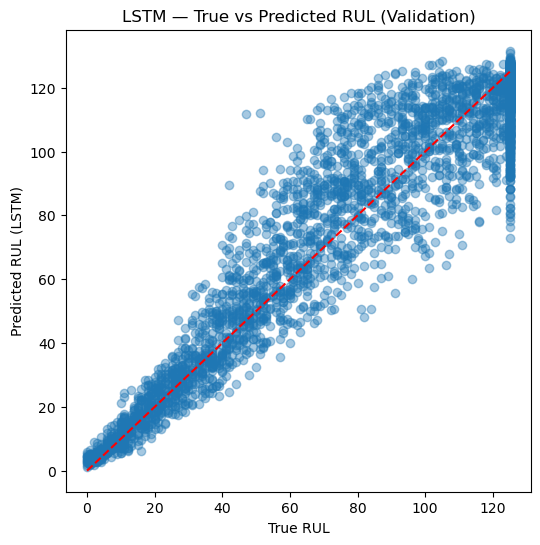

In [7]:

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred_lstm, alpha=0.4)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL (LSTM)")
plt.title("LSTM — True vs Predicted RUL (Validation)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.show()


## 6. GRU Model

We now train a GRU-based model, which is similar to LSTM but slightly simpler 
and often faster to train.

In [8]:
def build_gru_model(seq_len, n_features):
    model = Sequential([
        GRU(64, input_shape=(seq_len, n_features), return_sequences=False),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae"]
    )
    return model

gru_model = build_gru_model(sequence_length, num_features)
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14976     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,089
Trainable params: 17,089
Non-trainable params: 0
_________________________________________________________________


## 7. Train GRU Model

In [9]:
gru_checkpoint_path = models_dir / "gru_fd001_best.h5"

checkpoint_gru = ModelCheckpoint(
    filepath=str(gru_checkpoint_path),
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop_gru = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_gru, checkpoint_gru],
    verbose=1
)

Epoch 1/100
221/221 [==============================] - ETA: 0s - loss: 3903.6458 - mae: 52.4965
Epoch 1: val_loss improved from inf to 1759.77014, saving model to C:\Users\Kal\Predictive Maintenance Aircraft Engine\models\gru_fd001_best.h5
221/221 [==============================] - 3s 9ms/step - loss: 3903.6458 - mae: 52.4965 - val_loss: 1759.7701 - val_mae: 37.4103
Epoch 2/100
217/221 [============================>.] - ETA: 0s - loss: 1771.1449 - mae: 37.2455
Epoch 2: val_loss improved from 1759.77014 to 1701.48596, saving model to C:\Users\Kal\Predictive Maintenance Aircraft Engine\models\gru_fd001_best.h5
221/221 [==============================] - 2s 7ms/step - loss: 1770.7689 - mae: 37.2434 - val_loss: 1701.4860 - val_mae: 36.7696
Epoch 3/100
214/221 [============================>.] - ETA: 0s - loss: 1217.1526 - mae: 29.8360
Epoch 3: val_loss improved from 1701.48596 to 602.25531, saving model to C:\Users\Kal\Predictive Maintenance Aircraft Engine\models\gru_fd001_best.h5
221/221 [

## 8. Evaluate GRU Performance


In [10]:
y_val_pred_gru = gru_model.predict(X_val).ravel()
evaluate_regression(y_val, y_val_pred_gru, label="GRU")

111/111 [==============================] - 0s 2ms/step
GRU — MAE: 10.05, RMSE: 13.68


(10.05129623413086, 13.679093518479384)

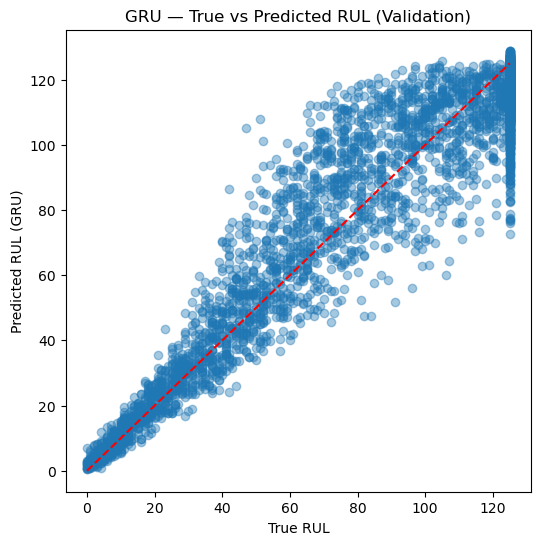

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred_gru, alpha=0.4)
plt.xlabel("True RUL")
plt.ylabel("Predicted RUL (GRU)")
plt.title("GRU — True vs Predicted RUL (Validation)")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")
plt.show()

## 9. Compare LSTM vs GRU

We compare both models using MAE and RMSE on the same validation set.


In [12]:
print("LSTM performance:")
mae_lstm, rmse_lstm = evaluate_regression(y_val, y_val_pred_lstm, label="LSTM")

print("\nGRU performance:")
mae_gru, rmse_gru = evaluate_regression(y_val, y_val_pred_gru, label="GRU")

print("\nSummary:")
print(f"LSTM — MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")
print(f"GRU  — MAE: {mae_gru:.2f}, RMSE: {rmse_gru:.2f}")

LSTM performance:
LSTM — MAE: 9.59, RMSE: 13.25

GRU performance:
GRU — MAE: 10.05, RMSE: 13.68

Summary:
LSTM — MAE: 9.59, RMSE: 13.25
GRU  — MAE: 10.05, RMSE: 13.68


## 10. Week 3 Summary

In this notebook, we:

- Loaded processed training sequences (`X_train_fd001.npy`, `y_train_fd001.npy`)
- Split the data into training and validation sets
- Built and trained an LSTM model for RUL prediction
- Built and trained a GRU model for comparison
- Evaluated both models using MAE and RMSE
- Saved best-performing models as `.h5` files in the `models/` directory

Next step: **Week 4 — Build a Streamlit dashboard to visualize RUL predictions and 
simulate an airline maintenance control panel.**
